In [16]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [17]:
#자연발생 클러스터링(민원 단계 컬럼 생성)
from jenkspy import JenksNaturalBreaks

parks_df = pd.read_csv("src/RF_parksdf_week.csv")
#parks_df = pd.read_csv("src/RF_parksdf_sat.csv")
#parks_df = pd.read_csv("src/RF_parksdf_holi.csv")

# 1) IQR 계산
Q1 = parks_df["complaints_r300"].quantile(0.25)
Q3 = parks_df["complaints_r300"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 2) 이상치 제거
outliers = parks_df[
    (parks_df["complaints_r300"] < lower_bound) |
    (parks_df["complaints_r300"] > upper_bound)
].copy()

parks_df = parks_df.drop(outliers.index).copy()

# 3) 필터된 데이터로 Jenks 적용
i = 3
breaks = JenksNaturalBreaks(n_classes=i)
breaks.fit(parks_df["complaints_r300"])
print("경계값:", breaks.breaks_)

# 4) 레이블 부여
parks_df["complaint_level"] = pd.cut(
    parks_df["complaints_r300"],
    bins=breaks.breaks_,
    labels=range(i),
    include_lowest=True
)
parks_df["complaint_level"].value_counts()

경계값: [0, 913, 2107, 4099]


complaint_level
0    800
1    459
2    273
Name: count, dtype: int64

In [62]:
print(len(outliers))
print(outliers.columns)

93
Index(['address', 'parking_type', 'operation_type', 'total_parking_spaces',
       'base_parking_fee', 'base_parking_time', 'additional_unit_fee',
       'additional_unit_time', 'fee1H', 'cctv_r300', 'bus_r300',
       'complaints_r300', 'Weekday_paid', 'Weekday_operatingHours', 'lon',
       'lat', 'zoning_encoded', 'start_sin', 'start_cos', 'end_sin',
       'end_cos'],
      dtype='object')


In [39]:
## 범주형 뺀 ver

# ─── 1) 이상치(outliers) 그룹 복사 ──────────────────────────────────────────
df_out = outliers.copy()

df_out["Weekday_paid"] = df_out["Weekday_paid"].map({"Y":1, "N":0})

# ─── 2) 분석에 사용할 피처 리스트 정의 ───────────────────────────────────────
features = [
    "total_parking_spaces",
    "fee1H",
    "cctv_r300",
    "bus_r300",
    "Weekday_operatingHours"
]
'''
# ─── 3) 이상치 그룹 기술통계 출력 ───────────────────────────────────────────
print("=== 이상치 그룹 기술통계 ===")
print(df_out[features].describe())

# ─── 4) 각 피처 분포 시각화 (박스플롯) ──────────────────────────────────────
import matplotlib.pyplot as plt

for col in features:
    plt.figure(figsize=(6,3))
    plt.boxplot(df_out[col].dropna(), vert=False)
    plt.title(f"Outliers: {col} 분포")
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()

'''
# ─── 5) 이상치 그룹 내부 클러스터링 (K-Means 예시) ──────────────────────────
from sklearn.cluster import KMeans

# 클러스터 개수 설정 (예: 2)
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
df_out["subcluster"] = kmeans.fit_predict(df_out[features])

cluster_means = df_out.groupby("subcluster")[features].mean()

# 5) 전체 데이터 분포에서의 백분위 계산 함수
def percentile_rank(global_series, value):
    return (global_series <= value).sum() / len(global_series) * 100

# 6) 각 클러스터 평균값의 백분위 테이블 생성
pr_table = pd.DataFrame(index=cluster_means.index, columns=features)
for feat in features:
    global_vals = df_out[feat]  # 전체 이상치가 아닌, 전체 parks_df를 쓰고 싶으면 parks_df[feat]로 변경
    for cl in cluster_means.index:
        val = cluster_means.loc[cl, feat]
        pr_table.loc[cl, feat] = percentile_rank(global_vals, val).round(1)


# 서브클러스터별 평균 프로파일 확인
print("\n=== Outliers 내부 서브클러스터 평균 프로파일 ===")
print(cluster_means)

print("\n...")
print(pr_table)

# ─── 6) 서브클러스터별 샘플 개수 확인 ────────────────────────────────────
print("\n=== Subcluster별 샘플 수 ===")
print(df_out["subcluster"].value_counts())


=== Outliers 내부 서브클러스터 평균 프로파일 ===
            total_parking_spaces        fee1H  cctv_r300   bus_r300  \
subcluster                                                            
0                      45.304348  4215.652174   5.652174  10.326087   
1                      69.574468  1292.127660   3.531915   7.936170   

            Weekday_operatingHours  
subcluster                          
0                        13.043478  
1                        19.553191  

...
           total_parking_spaces fee1H cctv_r300 bus_r300  \
subcluster                                                 
0                          73.1  76.3      71.0     66.7   
1                          75.3  25.8      53.8     48.4   

           Weekday_operatingHours  
subcluster                         
0                            57.0  
1                            57.0  

=== Subcluster별 샘플 수 ===
subcluster
1    47
0    46
Name: count, dtype: int64


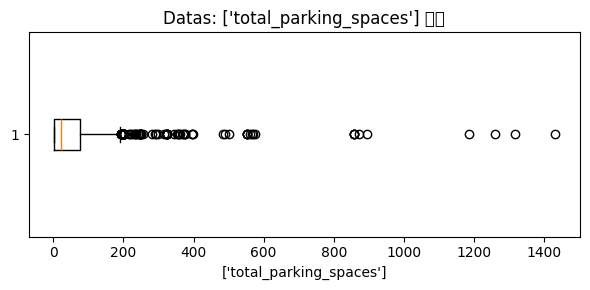

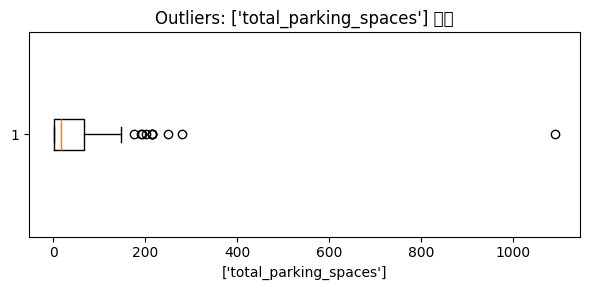

In [59]:
import matplotlib.pyplot as plt

col = ["total_parking_spaces"]

plt.figure(figsize=(6,3))
plt.boxplot(parks_df[col].dropna(), vert=False)
plt.title(f"Datas: {col} 분포")
plt.xlabel(col)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,3))
plt.boxplot(df_out[col].dropna(), vert=False)
plt.title(f"Outliers: {col} 분포")
plt.xlabel(col)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np

parks_df = pd.read_csv("RF_parksdf_week.csv", encoding="utf-8")

parks_df['start_sin'] = np.sin(2 * np.pi * parks_df['Weekday_start'] / 24)
parks_df['start_cos'] = np.cos(2 * np.pi * parks_df['Weekday_start'] / 24)
parks_df['end_sin']   = np.sin(2 * np.pi * parks_df['Weekday_end']   / 24)
parks_df['end_cos']   = np.cos(2 * np.pi * parks_df['Weekday_end']   / 24)

parks_df.to_csv("RF_parksdf_week.csv", index=False, encoding="utf-8")


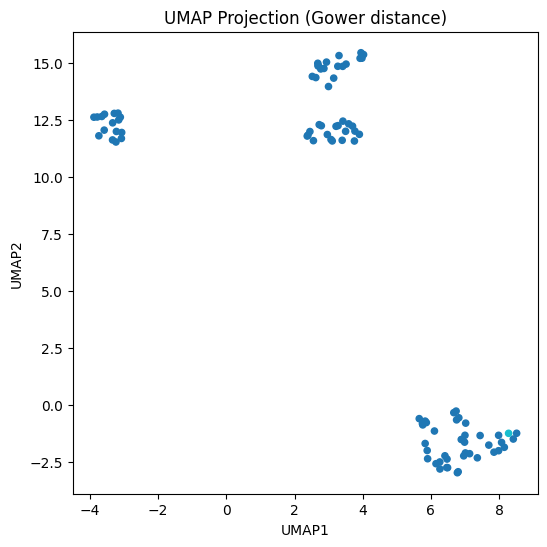

In [54]:
## test ..

from gower import gower_matrix
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
import matplotlib.pyplot as plt

# ─── 1) 이상치(outliers) 그룹 복사 ──────────────────────────────────────────
df_out = outliers.copy()

df_out["Weekday_paid"] = df_out["Weekday_paid"].map({"Y":1, "N":0})

# ─── 2) 분석에 사용할 피처 리스트 정의 ───────────────────────────────────────
features = [
    "total_parking_spaces",
    "fee1H",
    "cctv_r300",
    "bus_r300",
    "Weekday_operatingHours"
]

df_mix = df_out[features]

# 2) Gower 거리 계산 (N×N 행렬)
D = gower_matrix(df_mix)

# 3) 계층적 군집화 (average linkage)
Z = linkage(D, method="average")
'''plt.figure(figsize=(8,4))
dendrogram(Z, no_labels=True, color_threshold=0.5*max(Z[:,2]))
plt.show()'''

# 4) 군집 수 정해서 레이블 부여
k = 2
df_out["subcluster"] = fcluster(Z, k, criterion="maxclust")

# umap-learn 설치가 안 되어 있다면 (터미널 또는 노트북에서):
# !pip install umap-learn gower

# 올바른 임포트
from umap.umap_ import UMAP
from gower import gower_matrix
import matplotlib.pyplot as plt

# 혼합형 변수 DataFrame(df_mix) 준비
# 예: df_mix = df_out[feats]

# 1) Gower 거리 계산
D = gower_matrix(df_mix)

# 2) UMAP 임베딩 (precomputed 거리 매트릭스 사용)
reducer = UMAP(metric="precomputed", random_state=42)
embedding = reducer.fit_transform(D)

# 3) 결과 시각화
plt.figure(figsize=(6,6))
plt.scatter(
    embedding[:,0], embedding[:,1],
    c=df_out["subcluster"],  # 또는 kp_cluster, dbscan_cluster 등
    cmap="tab10", s=20
)
plt.title("UMAP Projection (Gower distance)")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.show()


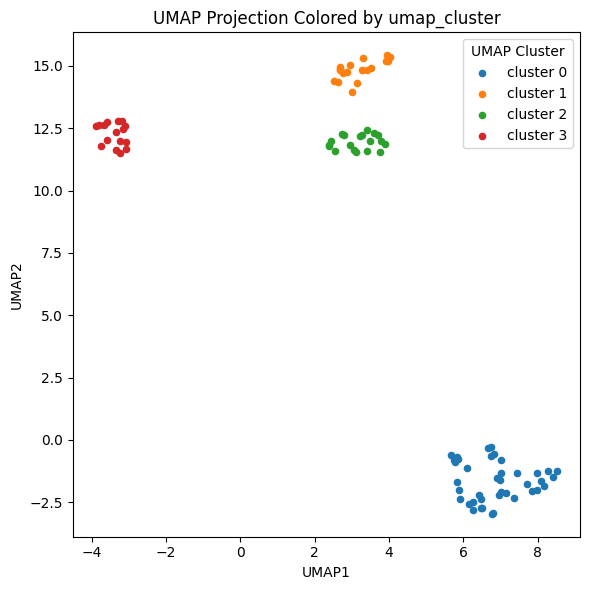

In [60]:
import matplotlib.pyplot as plt

# embedding: (n_samples,2)인 UMAP 결과 배열
# df_out["umap_cluster"]: 각 점의 군집 라벨

plt.figure(figsize=(6,6))
for clus in sorted(df_out["umap_cluster"].unique()):
    mask = df_out["umap_cluster"] == clus
    plt.scatter(
        embedding[mask,0],
        embedding[mask,1],
        label=f"cluster {clus}",
        s=20
    )
plt.legend(title="UMAP Cluster")
plt.title("UMAP Projection Colored by umap_cluster")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.tight_layout()
plt.show()


In [55]:
from sklearn.cluster import DBSCAN
import numpy as np

# embedding: (n_samples, 2) 형태의 UMAP 결과
db = DBSCAN(eps=1.0, min_samples=5)   # eps는 거리에 따라 조정
clusters = db.fit_predict(embedding)

# df_out에 새 컬럼으로 붙이기
df_out["umap_cluster"] = clusters
print(df_out["umap_cluster"].value_counts())

umap_cluster
0    40
2    19
1    18
3    16
Name: count, dtype: int64


In [56]:
# 예: 숫자 피처 요약
num_feats = ["total_parking_spaces","fee1H","cctv_r300","bus_r300"]
print(df_out.groupby("umap_cluster")[num_feats].agg(["mean","median","count"]))

# 예: Weekday_paid 비율
print(pd.crosstab(df_out["umap_cluster"], df_out["Weekday_paid"], normalize="index"))

             total_parking_spaces                     fee1H                \
                             mean median count         mean  median count   
umap_cluster                                                                
0                      119.575000   65.0    40  1721.750000  1500.0    40   
1                        6.500000    1.0    18  5533.333333  6000.0    18   
2                       15.789474    1.0    19  2388.421053  3000.0    19   
3                        9.625000    1.0    16  2550.000000  2400.0    16   

             cctv_r300                bus_r300               
                  mean median count       mean median count  
umap_cluster                                                 
0             5.075000    3.0    40   7.225000    6.0    40  
1             7.111111    7.0    18  11.888889   10.5    18  
2             2.578947    3.0    19   6.578947    6.0    19  
3             2.875000    3.0    16  13.750000   12.0    16  
Weekday_paid     0     1
u

In [20]:
print(parks_df.columns)

Index(['address', 'parking_type', 'operation_type', 'total_parking_spaces',
       'base_parking_fee', 'base_parking_time', 'additional_unit_fee',
       'additional_unit_time', 'fee1H', 'cctv_r300', 'bus_r300',
       'complaints_r300', 'Weekday_paid', 'Weekday_operatingHours', 'lon',
       'lat', 'zoning_encoded', 'start_sin', 'start_cos', 'end_sin', 'end_cos',
       'complaint_level'],
      dtype='object')


In [21]:
'''# KMeans 기반 클러스터링

from sklearn.cluster import KMeans
import numpy as np
import pandas as pd

parks_df = pd.read_csv("src/RF_parksdf_week.csv")
#parks_df = pd.read_csv("src/RF_parksdf_sat.csv")
#parks_df = pd.read_csv("src/RF_parksdf_holi.csv")
parks_df.columns

# 1) IQR 계산
Q1 = parks_df["complaints_r300"].quantile(0.25)
Q3 = parks_df["complaints_r300"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 2) 이상치 제거
parks_df = parks_df[
    (parks_df["complaints_r300"] >= lower_bound) &
    (parks_df["complaints_r300"] <= upper_bound)
].copy()

k = 3

X = parks_df["complaints_r300"].values.reshape(-1, 1)

kmeans = KMeans(n_clusters=k, random_state=0)
clusters = kmeans.fit_predict(X)

centers = kmeans.cluster_centers_.flatten()
sorted_idx = np.argsort(centers)
label_map = {old: new for new, old in enumerate(sorted_idx)}
sorted_labels = np.vectorize(label_map.get)(clusters)

parks_df["complaint_level"] = sorted_labels

parks_df["complaint_level"].value_counts().sort_index()
'''

'# KMeans 기반 클러스터링\n\nfrom sklearn.cluster import KMeans\nimport numpy as np\nimport pandas as pd\n\nparks_df = pd.read_csv("src/RF_parksdf_week.csv")\n#parks_df = pd.read_csv("src/RF_parksdf_sat.csv")\n#parks_df = pd.read_csv("src/RF_parksdf_holi.csv")\nparks_df.columns\n\n# 1) IQR 계산\nQ1 = parks_df["complaints_r300"].quantile(0.25)\nQ3 = parks_df["complaints_r300"].quantile(0.75)\nIQR = Q3 - Q1\nlower_bound = Q1 - 1.5 * IQR\nupper_bound = Q3 + 1.5 * IQR\n\n# 2) 이상치 제거\nparks_df = parks_df[\n    (parks_df["complaints_r300"] >= lower_bound) &\n    (parks_df["complaints_r300"] <= upper_bound)\n].copy()\n\nk = 3\n\nX = parks_df["complaints_r300"].values.reshape(-1, 1)\n\nkmeans = KMeans(n_clusters=k, random_state=0)\nclusters = kmeans.fit_predict(X)\n\ncenters = kmeans.cluster_centers_.flatten()\nsorted_idx = np.argsort(centers)\nlabel_map = {old: new for new, old in enumerate(sorted_idx)}\nsorted_labels = np.vectorize(label_map.get)(clusters)\n\nparks_df["complaint_level"] = sorted_labe

In [22]:
#범주형 변수의 label을 [0,1]로 변환
from sklearn.preprocessing import LabelEncoder

le_dict = {}

for col in ["parking_type", "operation_type", "Weekday_paid", "Saturday_paid", "Holiday_paid"]:
    if col in parks_df.columns:  # ✅ 존재하는 경우에만 처리
        le = LabelEncoder()
        parks_df[col] = le.fit_transform(parks_df[col])
        le_dict[col] = le

# 예시: parking_type의 범주와 정수 매핑 확인
for col in le_dict:
    print(f"{col}: {list(le_dict[col].classes_)}")

# [0, 1, 2, ...] 순서로 classes_에 저장됨
#['NS', 'NW'] -> [0,1]
#[1, 3] -> [0,1]
#['N', 'Y'] -> [0,1]
#['N', 'Y'] -> [0,1]
#['N', 'Y'] -> [0,1]

parking_type: ['NS', 'NW']
operation_type: [1, 3]
Weekday_paid: ['N', 'Y']


In [23]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd

# 0) 데이터 준비axis=
X = parks_df.drop(["complaints_r300", "complaint_level", "address", "lat", "lon",
                   "base_parking_fee", "base_parking_time", "additional_unit_fee", "additional_unit_time", "zoning_encoded"], axis=1)
y = parks_df["complaint_level"]

# 1) 80%를 train+val, 20%를 test로 분리 (stratify 유지)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# 2) train_val(80%) 중 12.5%를 val로 → 전체 비율 10%, train은 70%
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    test_size=0.125,    # 0.8 * 0.125 = 0.1
    stratify=y_train_val,
    random_state=42
)

# 3) 훈련셋에서만 RandomForest로 피처 중요도 계산
rf_fs = RandomForestClassifier(random_state=0)
rf_fs.fit(X_train, y_train)

importances = pd.Series(rf_fs.feature_importances_, index=X_train.columns)
top10 = importances.nlargest(10).index.tolist()
print("선택된 상위 10개 피처:", top10)

if 'start_sin' in top10 and 'start_cos' not in top10:
    top10.append('start_cos')
if 'start_cos' in top10 and 'start_sin' not in top10:
    top10.append('start_sin')
# 이렇게 하면 둘이 반드시 함께 들어감


# 4) 선택된 피처로 데이터 재정의
X_train_sel = X_train[top10]
X_val_sel   = X_val[top10]
X_test_sel  = X_test[top10]

# 5) 최종 모델 학습 & 평가
rf = RandomForestClassifier(
    random_state=0,
    class_weight="balanced"   # 클래스 불균형 보정
)
rf.fit(X_train_sel, y_train)

val_pred  = rf.predict(X_val_sel)
test_pred = rf.predict(X_test_sel)

print("Validation 정확도: {:.4f}".format(accuracy_score(y_val, val_pred)))
print("Test 정확도      : {:.4f}".format(accuracy_score(y_test, test_pred)))


선택된 상위 10개 피처: ['total_parking_spaces', 'bus_r300', 'cctv_r300', 'fee1H', 'Weekday_operatingHours', 'end_sin', 'end_cos', 'start_sin', 'start_cos', 'operation_type']
Validation 정확도: 0.6169
Test 정확도      : 0.7296


In [24]:
# Accuracy 분석

from sklearn.metrics import classification_report, accuracy_score

print("Complaint Level (Kmeans) Classification Accuracy:", round(accuracy_score(y_test, test_pred), 3))
print(classification_report(y_test, test_pred, target_names=['Low', 'Mid', 'High']))

Complaint Level (Kmeans) Classification Accuracy: 0.73
              precision    recall  f1-score   support

         Low       0.85      0.88      0.86       160
         Mid       0.60      0.55      0.58        92
        High       0.58      0.60      0.59        55

    accuracy                           0.73       307
   macro avg       0.68      0.68      0.68       307
weighted avg       0.73      0.73      0.73       307



In [14]:
importances = rf.feature_importances_
feature_names = top10  # DataFrame에서 feature 이름 추출

# 중요도 표 만들기
importance_table = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

importance_table


,feature,importance
0,total_parking_spaces,0.225239
1,bus_r300,0.196104
3,fee1H,0.175595
2,cctv_r300,0.155748
6,end_cos,0.062120
5,end_sin,0.053904
4,Weekday_operatingHours,0.052679
9,operation_type,0.026863
7,start_sin,0.026162
8,start_cos,0.025584


In [15]:
import numpy as np
import pandas as pd
import shap

# ── 1) 기존 mean_abs_shap 계산 (axis=0 으로 피처별 평균 절댓값 SHAP) ─────
explainer = shap.TreeExplainer(rf)
shap_vals = explainer.shap_values(X_train_sel)

mean_abs_shap = pd.DataFrame({
    f'class_{cls}': np.abs(shap_vals[cls]).mean(axis=1)
    for cls in range(len(shap_vals))
}, index=top10)

# ── 2) start_time, end_time 그룹 중요도 (Euclidean norm) 계산 ──────────
for cls in mean_abs_shap.columns:
    # start_time
    s_sin = mean_abs_shap.loc['start_sin', cls]
    s_cos = mean_abs_shap.loc['start_cos', cls]
    mean_abs_shap.loc['start_time', cls] = np.sqrt(s_sin**2 + s_cos**2)
    # end_time
    e_sin = mean_abs_shap.loc['end_sin', cls]
    e_cos = mean_abs_shap.loc['end_cos', cls]
    mean_abs_shap.loc['end_time', cls] = np.sqrt(e_sin**2 + e_cos**2)

# ── 3) sin/cos 개별 행 제거하여 그룹화된 DataFrame 구성 ────────────────
grouped_shap = mean_abs_shap.drop(
    ['start_sin','start_cos','end_sin','end_cos'],
    axis=0
)

# ── 4) 클래스별 상위 N개 피처 출력 ──────────────────────────────────
top_n = 5
for cls in grouped_shap.columns:
    print(f"\n▶ {cls} 기여도 상위 {top_n}개 피처")
    print(grouped_shap[cls].sort_values(ascending=False).head(top_n))



▶ class_0 기여도 상위 5개 피처
end_time                  0.125475
fee1H                     0.095519
Weekday_operatingHours    0.061782
cctv_r300                 0.034981
bus_r300                  0.020227
Name: class_0, dtype: float64

▶ class_1 기여도 상위 5개 피처
cctv_r300                 0.085584
fee1H                     0.064939
end_time                  0.038422
bus_r300                  0.029805
Weekday_operatingHours    0.022860
Name: class_1, dtype: float64

▶ class_2 기여도 상위 5개 피처
end_time                  0.107567
operation_type            0.079873
Weekday_operatingHours    0.059192
bus_r300                  0.049385
fee1H                     0.048628
Name: class_2, dtype: float64

▶ class_3 기여도 상위 5개 피처
bus_r300                  0.076570
cctv_r300                 0.075910
fee1H                     0.058186
end_time                  0.057149
Weekday_operatingHours    0.041381
Name: class_3, dtype: float64

▶ class_4 기여도 상위 5개 피처
cctv_r300                 0.085931
bus_r300                 

In [ ]:
'''
# gradient boosting
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(random_state=0)
gb.fit(X_train, y_train)
pred = gb.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print('gradient boosting 정확도: {:.4f}'.format(accuracy))
'''

In [ ]:
## 행정동별 분석

In [32]:
from sklearn.metrics import mean_squared_error
import pandas as pd
pd.set_option('display.max_rows', None)

# 여기 요일타입에 따라 바꿔야 됩니다!!
dong_parks_df = pd.read_csv("src/dongParks_Weekday.csv")
dong_parks_df

# dong_parks_df의 feature 컬럼만 추출 (dong 이름 등 식별자 제외)
# 모델이 학습할 때 사용한 feature 리스트
model_features = list(rf.feature_names_in_)

# dong_parks_df에서 해당 컬럼만 추출
X_dong = dong_parks_df[model_features]
# 동별 민원 수준 예측
dong_parks_df['predicted_complaints'] = rf.predict(X_dong)

# 그룹별 동 이름 추출
high_dong = dong_parks_df[dong_parks_df['predicted_complaints'] == 2]['dong']
mid_dong = dong_parks_df[dong_parks_df['predicted_complaints'] == 1]['dong']
low_dong = dong_parks_df[dong_parks_df['predicted_complaints'] == 0]['dong']

# 각 그룹을 DataFrame으로 변환 (인덱스 리셋)
high_df = pd.DataFrame({'High 민원': high_dong.reset_index(drop=True)})
mid_df = pd.DataFrame({'Mid 민원': mid_dong.reset_index(drop=True)})
low_df = pd.DataFrame({'Low 민원': low_dong.reset_index(drop=True)})

# 길이가 다른 경우도 맞춰서 하나의 표로 합치기
dong_table = pd.concat([high_df, mid_df, low_df], axis=1)

from IPython.display import display
display(dong_table.head())

,High 민원,Mid 민원,Low 민원
0,가락본동,가리봉동,가산동
1,고덕2동,강일동,가양1동
2,구로2동,개포3동,가양2동
3,구로3동,거여2동,가양3동
4,구로4동,구산동,갈현1동


In [33]:
import pandas as pd

pd.Series(rf.feature_importances_, index=X_dong.columns).sort_values(ascending=False)

total_parking_spaces      0.225239
bus_r300                  0.196104
fee1H                     0.175595
cctv_r300                 0.155748
end_cos                   0.062120
end_sin                   0.053904
Weekday_operatingHours    0.052679
operation_type            0.026863
start_sin                 0.026162
start_cos                 0.025584
dtype: float64

In [34]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler


scaler = RobustScaler()
X_scaled = pd.DataFrame(
    scaler.fit_transform(X_dong),
    columns=X_dong.columns
)

'''
# 정규화 수행
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_dong), columns=X_dong.columns)
'''

# 정규화된 데이터 기준으로 영향력 큰 feature 추정
importances = rf.feature_importances_
dong_parks_df['top_feature'] = X_scaled.apply(
    lambda row: row.index[np.argmax(np.abs(row.values * importances))],
    axis=1
)

# 결과 출력
solution_table = dong_parks_df[['dong', 'predicted_complaints', 'top_feature']]
display(solution_table.head())

# 민원 수준별 요약
summary = solution_table.groupby('predicted_complaints')['top_feature'].value_counts()
print(summary)


,dong,predicted_complaints,top_feature
0,가락본동,2,cctv_r300
1,가리봉동,1,total_parking_spaces
2,가산동,0,bus_r300
3,가양1동,0,total_parking_spaces
4,가양2동,0,bus_r300


predicted_complaints  top_feature         
0                     fee1H                   56
                      bus_r300                52
                      total_parking_spaces    52
                      cctv_r300               25
1                     fee1H                   29
                      cctv_r300               18
                      bus_r300                15
                      total_parking_spaces    12
2                     cctv_r300               24
                      total_parking_spaces    15
                      bus_r300                12
                      fee1H                   11
Name: count, dtype: int64


In [36]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# 1) 행정동 경계 불러오기 (EPSG:5179)
dong_boundaries = (
    gpd.read_file("src/dong_boundary.shp")
       .rename(columns={"ADM_NM":"dong"})
)

# 3) 주소에서 ‘○○동’ 부분만 추출해 두기
parks_df['addr_dong'] = parks_df['address'].str.extract(r'^\S+\s+(\S+동)')[0]

# 4) GeoDataFrame 생성 (위경도 → EPSG:4326 지정)
geometry = [Point(xy) for xy in zip(parks_df['lon'], parks_df['lat'])]
parks_gdf = gpd.GeoDataFrame(
    parks_df,
    geometry=geometry,
    crs="EPSG:4326"
)

# 5) 경계 CRS로 투영
parks_gdf = parks_gdf.to_crs(dong_boundaries.crs)

# ─────── 이 부분을 추가 ───────
# 6) 공간 결합
parks_gdf = gpd.sjoin(
    parks_gdf,
    dong_boundaries[['dong','geometry']],
    how='left',
    predicate='within'
)

# 7) NaN인 경우만 매핑 테이블로 보정
mapping = {
    '잠실동': '잠실본동',
    # 필요시 다른 주소-행정동도 여기에 추가
}
parks_gdf['dong'] = parks_gdf['dong'].fillna(
    parks_gdf['addr_dong'].map(mapping)
)
# ─────────────────────────────

# 8) 결과 확인
parks_gdf = parks_gdf.drop(columns=['addr_dong', 'geometry', 'index_right'])
print(parks_gdf.columns)


Index(['address', 'parking_type', 'operation_type', 'total_parking_spaces',
       'base_parking_fee', 'base_parking_time', 'additional_unit_fee',
       'additional_unit_time', 'fee1H', 'cctv_r300', 'bus_r300',
       'complaints_r300', 'Weekday_paid', 'Weekday_operatingHours', 'lon',
       'lat', 'zoning_encoded', 'start_sin', 'start_cos', 'end_sin', 'end_cos',
       'complaint_level', 'dong'],
      dtype='object')


In [37]:
import numpy as np
import pandas as pd
import shap

# 1) TreeExplainer 생성
explainer = shap.TreeExplainer(rf)
feature_cols = list(rf.feature_names_in_)

# 2) park-level SHAP 값 계산 (n_samples, n_features, n_classes)
raw_shap_p = explainer.shap_values(parks_gdf[feature_cols])

# 3) 클래스 차원 절댓값 평균 → (n_samples, n_features)
shap_abs_p = np.abs(raw_shap_p).mean(axis=2)

# 4) DataFrame으로 변환 후 dong 매핑
df_shap_p        = pd.DataFrame(shap_abs_p, columns=feature_cols)
df_shap_p['dong'] = parks_gdf['dong'].values

# 5) 행정동별 평균 SHAP 기여도 집계
dong_shap_mean = df_shap_p.groupby('dong').mean()

# 6) 행정동별 Top3 피처 추출
top3 = dong_shap_mean.apply(lambda row: row.nlargest(3).index.tolist(), axis=1)
df_top3 = (
    pd.DataFrame(top3.tolist(), index=top3.index, columns=['Top1','Top2','Top3'])
      .reset_index()
      .rename(columns={'index':'dong'})
)

# 7) 결과 확인
print(df_top3.head())


   dong                    Top1                  Top2                  Top3
0  가락본동                 end_cos                 fee1H               end_sin
1  가리봉동               cctv_r300  total_parking_spaces                 fee1H
2   가산동  Weekday_operatingHours               end_cos                 fee1H
3  가양1동               cctv_r300                 fee1H  total_parking_spaces
4  가양2동    total_parking_spaces              bus_r300             cctv_r300


In [38]:
# 1) 실제 complaints_level: parks_gdf 에 이미 있다면 바로 사용
#    없다면, 원본 complaints_df 등에서 행정동별로 집계해서 merge

# 예: 원본 parks_df 에 'complaints_level' 컬럼이 있다고 가정
actual = parks_gdf.groupby('dong')['complaint_level'] \
                   .agg(lambda x: x.mode()[0]) \
                   .reset_index()

# 2) 예측 complaints_level
predicted = pd.DataFrame({
    'dong': parks_gdf['dong'],
    'predicted_level': rf.predict(parks_gdf[feature_cols])
}).groupby('dong')['predicted_level'] \
  .agg(lambda x: x.mode()[0]) \
  .reset_index()

# 3) df_top3 에 결합
df_insight = (
    df_top3
      .merge(actual,    on='dong', how='left')
      .merge(predicted, on='dong', how='left')
)

df_insight.head()


,dong,Top1,Top2,Top3,complaint_level,predicted_level
0,가락본동,end_cos,fee1H,end_sin,2,2
1,가리봉동,cctv_r300,total_parking_spaces,fee1H,1,1
2,가산동,Weekday_operatingHours,end_cos,fee1H,0,0
3,가양1동,cctv_r300,fee1H,total_parking_spaces,0,0
4,가양2동,total_parking_spaces,bus_r300,cctv_r300,0,0
